In [59]:
import h3 # H3 Geospatial Indexing Library
import pandas as pd
import dask.dataframe as dd
import numpy as np
from tqdm.dask import TqdmCallback
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

GEO AUSWERTUNG

1. Importiere NYPD und Citibike Daten

In [ ]:
# NYPD
def add_h3_index(df, lat_col, lng_col, res=8):
    """Fügt einem DataFrame eine H3-Index-Spalte hinzu."""
    return df.apply(
        lambda row: h3.latlng_to_cell(row[lat_col], row[lng_col], res), 
        axis=1
    )


# Laden
df_nypd = pd.read_parquet('../data/processed/nypd/nypd_clean.parquet')

# H3-Zelle für jeden Unfall berechnen
print("Berechne H3 für NYPD...")
df_nypd['h3_cell'] = df_nypd.apply(
    lambda x: h3.latlng_to_cell(x['LATITUDE'], x['LONGITUDE'], 8), axis=1
)

# Aggregieren: Wie viele Unfälle pro H3-Zelle?
nypd_stats = df_nypd.groupby('h3_cell').agg({
    'crashes_with_bicycles_involved': 'sum',
    'NUMBER OF CYCLIST INJURED': 'sum',
    'NUMBER OF CYCLIST KILLED': 'sum'
}).rename(columns={'crashes_with_bicycles_involved': 'accident_count'}).reset_index()

nypd_stats.to_parquet('../data/processed/nypd/nypd_h3_stats.parquet', index=False)
print(f"NYPD fertig. {len(nypd_stats)} Zellen mit Unfällen identifiziert.")

In [ ]:
# Citibike
ddf_citibike = dd.read_parquet('../data/processed/citibike/citibike_all_years_combined.parquet')

def process_citibike_partition(df):
    """Optimierte Version ohne langsames .apply()"""
    
    # 1. & 2. Schritt: Filtern (Vektorisiert und daher bereits sehr schnell)
    df = df.dropna(subset=['start_lat', 'start_lng'])
    
    mask = (
        (df['start_lat'] >= -90) & (df['start_lat'] <= 90) &
        (df['start_lng'] >= -180) & (df['start_lng'] <= 180) &
        (df['start_lat'] != 0) & (df['start_lng'] != 0)
    )
    df = df[mask]

    if df.empty:
        return df

    # 3. Schritt: H3-Berechnung beschleunigen
    # Wir ziehen die Daten aus dem DataFrame in NumPy-Arrays (viel schnellerer Zugriff)
    lats = df['start_lat'].to_numpy()
    lngs = df['start_lng'].to_numpy()
    
    # List Comprehension ist deutlich schneller als df.apply
    df['h3_cell'] = [h3.latlng_to_cell(lat, lng, 8) for lat, lng in zip(lats, lngs)]
        
    return df


print("Starte parallele H3-Berechnung für Citibike")
ddf_citibike = ddf_citibike.map_partitions(process_citibike_partition)

# Aggregieren: Wie viele Fahrten starten pro H3-Zelle?
citibike_stats = ddf_citibike.groupby('h3_cell').size().to_frame('trip_count').reset_index()

# WICHTIG: Erst jetzt berechnen wir das Gesamtergebnis
# Tqdm gibt Statusbalken aus
with TqdmCallback(desc="H3-Rasterung & Aggregation"):
    df_citibike_final = citibike_stats.compute()

df_citibike_final.to_parquet('../data/processed/citibike/citibike_h3_stats.parquet', index=False)

print(f"Citibike fertig. {len(df_citibike_final)} Zellen mit Startpunkten identifiziert.")

Starte parallele H3-Berechnung für Citibike


H3-Rasterung & Aggregation: 100%|██████████| 4006/4006 [09:17<00:00,  7.19it/s] 


Citibike fertig. 429 Zellen mit Startpunkten identifiziert.


2. Daten Zusammenführen: 
        Wir nutzen einen left join auf die Citibike-Daten, um auch Gebiete zu sehen, in denen viel gefahren wird, aber (zum Glück) keine Unfälle passierten.

In [20]:
# Zusammenführen
df_final = pd.merge(df_citibike_final, nypd_stats, on='h3_cell', how='left')

# NaN-Werte füllen (wo kein Unfall war, ist der Wert 0)
df_final[['accident_count', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']] = \
    df_final[['accident_count', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']].fillna(0)

3. Risiko-Metriken berechnen

In [ ]:
# Unfälle pro 100.000 Fahrten
df_final['accidents_per_100k'] = (df_final['accident_count'] / df_final['trip_count']) * 100000

# Ranking: Wo sind die Top 10 Gefahrenstellen?
top_danger = df_final.sort_values(by='accidents_per_100k', ascending=False).head(10)
print(top_danger)
# Entferne potenziell unendlich hohe Risikowerte (sehr wenige Fahrten, aber 1 Unfall)
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.dropna(subset=['accidents_per_100k'], inplace=True)

4. Karte erstellen (Heatmap)

In [ ]:
# --- 1. Daten für die Karte vorbereiten ---
# Optional: Nur Zellen mit >X Fahrten und >0 Unfällen betrachten, um Rauschen zu reduzieren
df_map_data = df_final[(df_final['trip_count'] > 100) & (df_final['accident_count'] > 0)].copy()

# Normierung des Risikowertes für die Farbgebung (optional, aber oft hilfreich)
min_risk = df_map_data['accidents_per_100k'].min()
max_risk = df_map_data['accidents_per_100k'].max()
print(f"Risikowerte reichen von {min_risk:.2f} bis {max_risk:.2f} Unfällen pro 100k Fahrten.")
# max_risk = 500
df_map_data['normalized_risk'] = (df_map_data['accidents_per_100k'] - min_risk) / (max_risk - min_risk)


thresholds = [0, 10, 100, 1000]

# Erstelle eine Farbskala (Gelb -> Orange -> Rot)
colormap = cm.StepColormap(
    # colors=["#ebffcc", '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026'],
    colors=["#ebffcc", '#fed976', '#fc4e2a', '#bd0026'],
    vmin=0,
    vmax=1010,
    index=thresholds,
    caption='Unfallrisiko pro 100k Fahrten'
)

# --- 2. Karte erstellen ---

# Startkoordinaten (ungefähres Zentrum von NYC)
nyc_coords = [40.730610, -73.935242] 
m = folium.Map(location=nyc_coords, zoom_start=12, tiles="CartoDB positron")

print("Erstelle Karte... Dies kann einen Moment dauern für viele H3-Zellen.")
def add_h3_polygon(row):
    geo_boundary = h3.cell_to_boundary(row['h3_cell'])
    
    # Die colormap-Funktion gibt uns automatisch die Farbe für den Wert zurück
    risk_value = row['accidents_per_100k']
    hex_color = colormap(risk_value)

    folium.Polygon(
        locations=geo_boundary,
        color='gray',
        weight=0.5,
        fill=True,
        fill_color=hex_color,
        fill_opacity=0.7,
        tooltip=(
            f"H3 Zelle: {row['h3_cell']}<br>"
            f"Fahrten: {int(row['trip_count']):,}<br>"
            f"Unfälle: {int(row['accident_count'])}<br>"
            f"Risiko: {risk_value:.2f}"
        )
    ).add_to(m)
# Iteriere über die Daten und füge jedes Hexagon zur Karte hinzu
# map_data.apply ist hier in Pandas ok, da es nur um die gefilterten Zellen geht
df_map_data.apply(add_h3_polygon, axis=1)
colormap.add_to(m)
# --- 4. Karte anzeigen und speichern ---
print("Karte ist fertig!")
m.save("../results/nypd_citibike_risk_map.html") # Speichert die Karte als HTML-Datei
m # Zeigt die Karte direkt im Jupyter Notebook an

Risikowerte reichen von 1.03 bis 44362.75 Unfällen pro 100k Fahrten.
Erstelle Karte... Dies kann einen Moment dauern für viele H3-Zellen.
Karte ist fertig!


ZEITLICHE ANALYSE

In [70]:
# Citibike laden (Dask)
ddf_citibike = dd.read_parquet('../data/processed/citibike/citibike_all_years_combined.parquet')

sample = ddf_citibike['started_at'].head(5)
print("So sehen deine Zeitstempel aus:")
print(sample)


# Mit Formatangabe (schneller und genauer)
def get_weekday_counts(df):
    """Konvertiert Zeitstempel und zählt Wochentage innerhalb einer Partition."""
    # Schnelles Format-Parsing (Passe das Format an, falls deine Daten anders aussehen)
    # Beispiel: '2023-05-01 12:00:00'
    times = pd.to_datetime(df['started_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    return times.dt.weekday.value_counts()

# print("Berechne Wochentag-Statistik für Citibike...")
with TqdmCallback(desc="Citibike Analyse"):
    # map_partitions reduziert die Daten sofort auf 7 Zeilen pro Partition
    citibike_results = ddf_citibike.map_partitions(get_weekday_counts).compute()


ddf_citibike.to_parquet('../data/processed/citibike/citibike_all_years_combined_fixed_datetime.parquet')

citibike_weekly = citibike_results.groupby(level=0).sum().sort_index()

# # Wochentag extrahieren (0=Montag, 6=Sonntag)
# # Annahme: Die Spalte heißt 'started_at' oder 'crash_datetime'
# ddf_citibike['weekday'] = ddf_citibike['started_at'].dt.weekday

# # Aggregieren pro Wochentag
# citibike_weekly = ddf_citibike.groupby('weekday').size().to_frame('trip_count').compute()
# citibike_weekly = citibike_weekly.sort_index()

So sehen deine Zeitstempel aus:
0    2014-01-01 00:00:06
1    2014-01-01 00:00:38
2    2014-01-01 00:03:59
3    2014-01-01 00:05:15
4    2014-01-01 00:05:18
Name: started_at, dtype: string


Citibike Analyse: 100%|██████████| 977/977 [13:12<00:00,  1.23it/s]


In [66]:
# NYPD laden (Pandas)
df_nypd = pd.read_parquet('../data/processed/nypd/nypd_clean.parquet')

# Wochentag extrahieren
df_nypd['weekday'] = df_nypd['crash_datetime'].dt.weekday

# Aggregieren
nypd_weekly = df_nypd.groupby('weekday').size().to_frame('accident_count').sort_index()

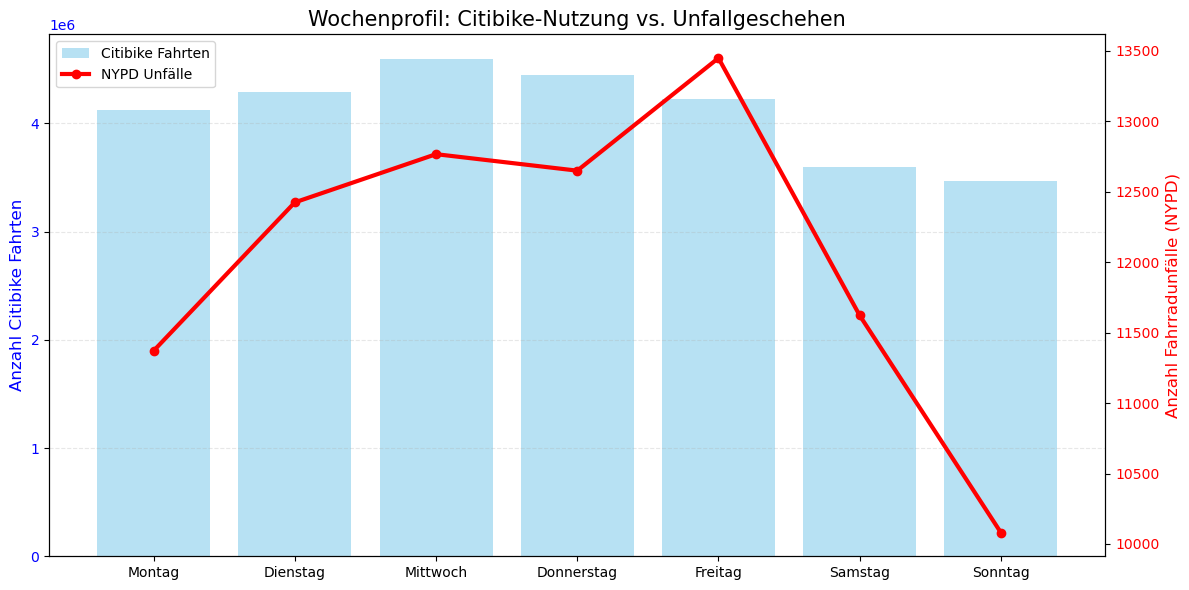

In [71]:
days = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']

fig, ax1 = plt.subplots(figsize=(12, 6))

# Balkendiagramm für Citibike
ax1.bar(days, citibike_weekly.values, color='skyblue', alpha=0.6, label='Citibike Fahrten')
ax1.set_ylabel('Anzahl Citibike Fahrten', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Zweite Achse für NYPD Unfälle
ax2 = ax1.twinx()
ax2.plot(days, nypd_weekly.values, color='red', marker='o', linewidth=3, label='NYPD Unfälle')
ax2.set_ylabel('Anzahl Fahrradunfälle (NYPD)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Wochenprofil: Citibike-Nutzung vs. Unfallgeschehen', fontsize=15)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Kombinierte Legende
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [77]:
# .squeeze() wandelt einen DataFrame mit nur einer Spalte in eine Series um
citibike_flat = citibike_weekly.squeeze()
nypd_flat = nypd_weekly.squeeze()

# 1. Daten zusammenführen in einem kleinen DataFrame
df_risk_weekly = pd.DataFrame({
    'trip_count': citibike_flat,
    'accident_count': nypd_flat
})

# 2. Risiko berechnen: Unfälle pro 1 Million Fahrten
# df_risk_weekly['risk_per_million'] = (df_risk_weekly['accident_count'] / df_risk_weekly['trip_count']) * 1_000_000
df_risk_weekly['risk_per_100k'] = (df_risk_weekly['accident_count'] / df_risk_weekly['trip_count']) * 100_000

# Wochentagsnamen für die Anzeige
days = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
df_risk_weekly['day_name'] = days

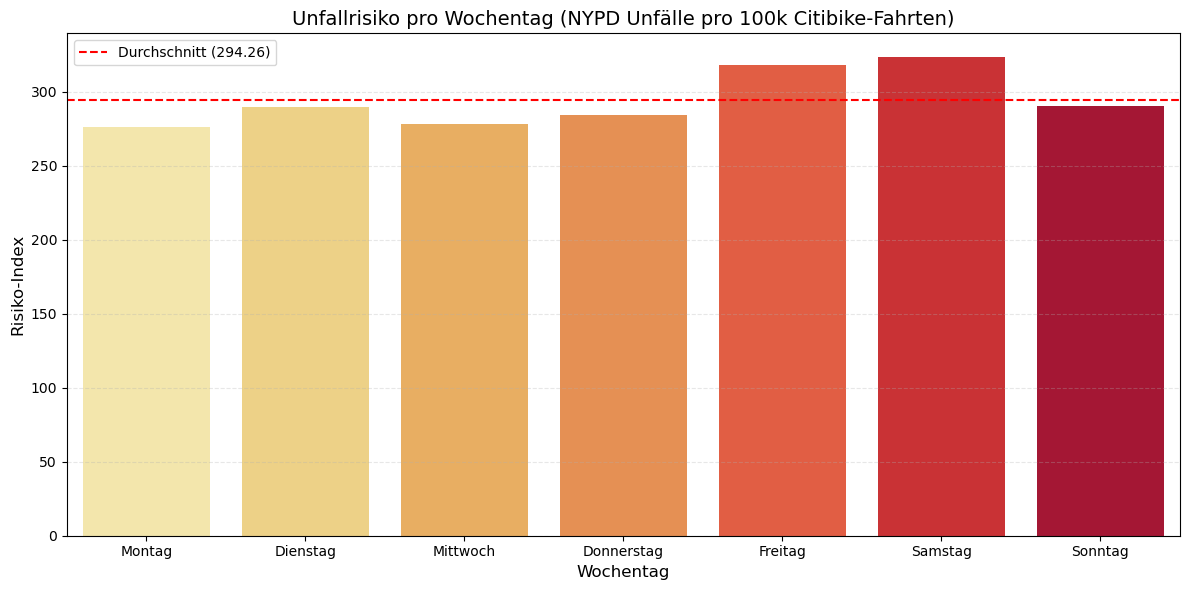

In [78]:
plt.figure(figsize=(12, 6))

# Plotten
sns.barplot(x='day_name', y='risk_per_100k', data=df_risk_weekly, palette='YlOrRd')

# Durchschnittslinie einfügen
avg_risk = df_risk_weekly['risk_per_100k'].mean()
plt.axhline(avg_risk, color='red', linestyle='--', label=f'Durchschnitt ({avg_risk:.2f})')

plt.title('Unfallrisiko pro Wochentag (NYPD Unfälle pro 100k Citibike-Fahrten)', fontsize=14)
plt.ylabel('Risiko-Index', fontsize=12)
plt.xlabel('Wochentag', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()